# AI now plays 2048!
In this notebook we will train an AI to play 2048 with reinforcement learning, and compare the results.

2048 is a popular sliding puzzle game back in 2014, with the goal of obtaining a tile of 2048 with combining smaller tiles that are also power of 2's, for example 2,4,8,...,1024.

![](https://upload.wikimedia.org/wikipedia/commons/6/64/2048_Screenshot.png)

# Part 1: Create a 2048 Game
First we have to create a playable 2048 game with the appropriate logic and behaviour in python code.

Reference: https://flothesof.github.io/2048-game.html.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from numpy import zeros, array, rot90
import random
import matplotlib.pyplot as plt
import math

In [ ]:
class Board():
    def __init__(self):
        self.board = zeros((4, 4), dtype=int)
        self.fill_cell()
        self.game_over = False
        self.total_score = 0
    
    def reset(self):
        self.__init__()
    
    # Adding a random 2/4 into the board
    def fill_cell(self):
      i, j = (self.board == 0).nonzero()
      if i.size != 0:
          rnd = random.randint(0, i.size - 1) 
          self.board[i[rnd], j[rnd]] = 2 * ((random.random() > .9) + 1)
    
    # Moving tiles in a column to left and merge if possible
    def move_left(self, col):
      new_col = zeros((4), dtype=col.dtype)
      j = 0
      previous = None
      for i in range(col.size):
          if col[i] != 0: # number different from zero
              if previous == None:
                  previous = col[i]
              else:
                  if previous == col[i]:
                      new_col[j] = 2 * col[i]
                      self.total_score += new_col[j]
                      j += 1
                      previous = None
                  else:
                      new_col[j] = previous
                      j += 1
                      previous = col[i]
      if previous != None:
          new_col[j] = previous
      return new_col

    def move(self, direction):
      # 0: left, 1: up, 2: right, 3: down
      rotated_board = rot90(self.board, direction)
      cols = [rotated_board[i, :] for i in range(4)]
      new_board = array([self.move_left(col) for col in cols])
      return rot90(new_board, -direction)
    
    def is_game_over(self):
      for i in range(self.board.shape[0]):
        for j in range(self.board.shape[1]):
          if self.board[i][j] == 0:
            return False
          if i != 0 and self.board[i - 1][j] == self.board[i][j]:
            return False
          if j != 0 and self.board[i][j - 1] == self.board[i][j]:
            return False
      return True

    
    def step(self, direction):
      new_board = self.move(direction)
      if not (new_board == self.board).all():
        self.board = new_board
        self.fill_cell()



In [ ]:
def main_loop(b, direction):
    new_board = b.move(direction)
    moved = False
    if (new_board == b.board).all():
        # move is invalid
        pass
    else:
        moved = True
        b.board = new_board
        b.fill_cell()
    return moved

In [ ]:
# Sample Game (Manual) (Skip this cell if you dont want to try the game manually)
game = Board()
finish = False
while not finish:
  direction = int(input("please enter a direction: (0) Left, (1) Up, (2) Right, (3) Down"))
  if direction < 0 or direction > 3:
    print("Not a valid input! Please enter a valid value (0/1/2/3)!")
    continue
  moved = main_loop(game, direction)
  if not moved:
    print("Not a valid move! Nothing has changed.")
    continue
  print(game.board)
  print(game.total_score)
  finish = game.is_game_over()
print("Game Over!, Total Score is {}".format(game.total_score))

KeyboardInterrupt: Interrupted by user

# Part 2: Baseline Result
In this section we will develop a naive strategy with choosing the next move randomly as the baseline experiment.

In [ ]:
def sample_game_random():
  game = Board()
  finish = False
  while not finish:
    direction = np.random.randint(4)
    moved = main_loop(game, direction)
    if not moved:
      # Sample another direction if the move is invalid
      continue
    finish = game.is_game_over()
  total_score = game.total_score
  best_tile = game.board.max()
  return total_score, best_tile

In [ ]:
scores_random, best_tiles_random = [], []
for i in range(1000):
  if i % 100 == 0:
    print(f"Iteration {i}")
  total_score, best_tile = sample_game_random()
  scores_random.append(total_score)
  best_tiles_random.append(best_tile)
print("Finish")


Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Finish


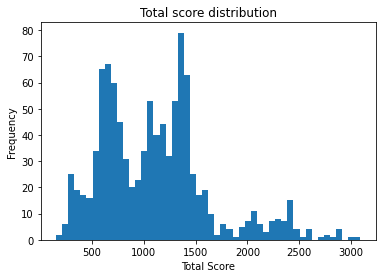

In [ ]:
# Plot best score distribution
plt.hist(scores_random, bins = 50)
plt.title("Total score distribution")
plt.xlabel("Total Score")
plt.ylabel("Frequency")
plt.show()


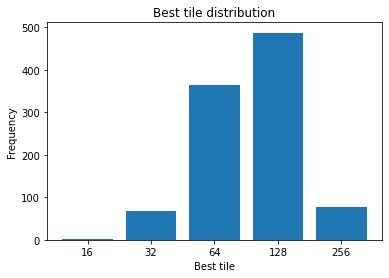

In [ ]:
# Plot best score distribution
max_power = int(math.log(max(best_tiles_random), 2)) + 1
min_power = int(math.log(min(best_tiles_random), 2))
unique, counts = np.unique(best_tiles_random, return_counts=True)
plt.bar([str(2 ** i) for i in range(min_power, max_power)], counts)
plt.title("Best tile distribution")
plt.xlabel("Best tile")
plt.ylabel("Frequency")
plt.show()


It seems that random move is not a good stretagy. Probably computer can learn how to choose the next move more intelligently...

# Part 3: Reinforcement Learning With Deep Q-Learning

In this section we will use Deep Q-Learning (DQN) to train the agent to play 2048.
Deep Q Learning is a model-free model, which means the algorithm does not learn the transitional function of the model directly. 

More about reinforcement learning and DQN: 

https://medium.com/swlh/introduction-to-reinforcement-learning-63fb8923bd88

https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc



Also DQN uses neural network as function approximation since the state space is too huge for this problem.

## State
The number of states in this model are $16^{16}$, since there are 4 * 4 = 16 grids in the game, and each game could take the value of 0, 2, $2^2=4$, $2^3=8$, ... , $2^{15} = 32768$.

Given the huge number of states, it is infeasible to use dynamic programming algorithm (e.g. SARSA / Q-Learning) to calculate $Q(s,a)$. Therefore approximating Q-value with deep neural network is required.

To represent the state of this model, a (4, 4, 16) dimensional numpy array is used, where first dimension represents row, second dimension represents column and third dimension represents the one-hot encoding of the value of the tile at that position. For example if 2 is in the top-left corner, then index [0, 0, 1] would be 1, and other entries in [0, 0, :] are 0.

## Reward
The reward for each action is defined as follows: For each merge in the move, the reward is the sum of the tiles after merging. For example, if [4, 4, 2, 2] is moved to left, it becomes [8, 4, 0, 0], with total score of 8 + 4 = 12 for that step.

## Q Learning Update
Below is the algorithm for Q-Learning, with $s_t$ being the current state, $a_t$ the current action, $r_t$ current reward and $s_{t+1}$ next state. These values are also stored in the memory as part of memory buffer.
<div>
<img src="https://i.imgur.com/RSlFts0.png" width="500"/>
</div>



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from collections import namedtuple, deque
from itertools import count

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def encode_state(board):
  board_flat = [0 if e == 0 else int(math.log(e, 2)) for e in board.flatten()]
  board_flat = torch.LongTensor(board_flat)
  board_flat = F.one_hot(board_flat, num_classes=16).float().flatten()
  board_flat = board_flat.reshape(1, 4, 4, 16).permute(0, 3, 1, 2)
  return board_flat


In [ ]:
# Defining the replay buffer
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ConvBlock, self).__init__()
        d = output_dim // 4
        self.conv1 = nn.Conv2d(input_dim, d, 1, padding='same')
        self.conv2 = nn.Conv2d(input_dim, d, 2, padding='same')
        self.conv3 = nn.Conv2d(input_dim, d, 3, padding='same')
        self.conv4 = nn.Conv2d(input_dim, d, 4, padding='same')

    def forward(self, x):
        x = x.to(device)
        output1 = self.conv1(x)
        output2 = self.conv2(x)
        output3 = self.conv3(x)
        output4 = self.conv4(x)
        return torch.cat((output1, output2, output3, output4), dim=1)

class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = ConvBlock(16, 2048)
        self.conv2 = ConvBlock(2048, 2048)
        self.conv3 = ConvBlock(2048, 2048)
        self.dense1 = nn.Linear(2048 * 16, 1024)
        self.dense6 = nn.Linear(1024, 4)
    
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = nn.Flatten()(x)
        x = F.dropout(self.dense1(x))
        return self.dense6(x)
    

In [ ]:
# Neural Network Initialisation and utilities
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 0.9999
TARGET_UPDATE = 20
n_actions = 4

policy_net = DQN().to(device)
target_net = DQN().to(device)
# target_net.load_state_dict(policy_net.state_dict())
policy_net.load_state_dict(torch.load('/content/drive/MyDrive/2048_reinforcement_learning/policy_net.pth'))
target_net.load_state_dict(torch.load('/content/drive/MyDrive/2048_reinforcement_learning/target_net.pth'))
target_net.eval()
policy_net.train()

optimizer = optim.Adam(policy_net.parameters(), lr=5e-5)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
memory = ReplayMemory(50000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = max(EPS_END, EPS_START * (EPS_DECAY ** steps_done))
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # global steps_done
    # if steps_done % 5000 == 0 and steps_done < 1000000:
    #   print("Learning rate changed.")
    #   scheduler.step()


In [ ]:
def same_move(state, next_state, last_memory):
  return torch.eq(state, last_memory.state).all() and torch.eq(next_state, last_memory.next_state).all()

In [ ]:
game = Board()
total_scores, best_tile_list = [], []

num_episodes = 5000
for i_episode in range(num_episodes):
    print(f"Episode {i_episode}")
    game.reset()
    state = encode_state(game.board).float()
    duplicate = False
    non_valid_count, valid_count = 0, 0
    for t in count():
        # Select and perform an action
        action = select_action(state)
        old_score = game.total_score
        old_max = game.board.max()
        game.step(action.item())

        done = game.is_game_over()

        reward = (game.total_score - old_score)
        reward = torch.tensor([reward], device=device)

        # Observe new state
        if not done:
            next_state = encode_state(game.board).float()
        else:
            next_state = None
        
        if next_state != None and torch.eq(state, next_state).all():
          non_valid_count += 1
          reward -= 10
        else:
          valid_count += 1

        # Store the transition in memory
        # if next_state != None and duplicate and not torch.eq(state, next_state).all():
        #   duplicate = False

        # if not duplicate:
        if next_state == None or len(memory) == 0 or not same_move(state, next_state, memory.memory[-1]):
          memory.push(state, action, next_state, reward)
        
        # if next_state != None:
        #   duplicate = torch.eq(state, next_state).all()
          
        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        # optimize_model()
        
        if done:
          for _ in range(100):
            optimize_model()

          print(game.board)
          print(f"Episode Score: {game.total_score}")
          print(f"Non valid move count: {non_valid_count}")
          print(f"Valid move count: {valid_count}")
          total_scores.append(game.total_score)
          best_tile_list.append(game.board.max())
          if i_episode > 50:
            average = sum(total_scores[-50:]) / 50
            print(f"50 episode running average: {average}")
          break

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        policy_net.train()
    
    if i_episode % 100 == 0:
        torch.save(policy_net.state_dict(), '/content/drive/MyDrive/2048_reinforcement_learning/policy_net.pth')
        torch.save(target_net.state_dict(), '/content/drive/MyDrive/2048_reinforcement_learning/target_net.pth')

print('Complete')


Streaming output truncated to the last 5000 lines.
Episode Score: 6012
Non valid move count: 295
Valid move count: 417
50 episode running average: 10898.8
Episode 445
[[   4    2    8    4]
 [   8   16   64    8]
 [   4   32  256   16]
 [ 512 2048  512    2]]
Episode Score: 30452
Non valid move count: 1608
Valid move count: 1593
50 episode running average: 11219.6
Episode 446
[[  4  32   4   2]
 [  8 512  16 256]
 [ 16  32  64   8]
 [  4   8   4   2]]
Episode Score: 6408
Non valid move count: 662
Valid move count: 431
50 episode running average: 11060.24
Episode 447
[[   2    4    2    4]
 [   8   64   16    2]
 [1024   32  128   16]
 [   4  256   64    2]]
Episode Score: 12412
Non valid move count: 480
Valid move count: 749
50 episode running average: 11202.08
Episode 448
[[   2    8   16    4]
 [   8   16    4   32]
 [ 512 1024  512    4]
 [   2    4   16    8]]
Episode Score: 17356
Non valid move count: 1506
Valid move count: 988
50 episode running average: 11305.84
Episode 449
[[  

In [ ]:
torch.save(policy_net.state_dict(), '/content/drive/MyDrive/2048_reinforcement_learning/policy_net.pth')
torch.save(target_net.state_dict(), '/content/drive/MyDrive/2048_reinforcement_learning/target_net.pth')

In [ ]:
print(total_scores)
print(best_tile_list)

[2952, 1352, 1960, 900, 1044, 1428, 1432, 1352, 612, 2404, 2280, 1828, 2152, 1520, 2452, 652, 1100, 1428, 188, 1528, 1336, 600, 1984, 964, 520, 2716, 2056, 1540, 3344, 1412, 2832, 1124, 3052, 3340, 2704, 2856, 3024, 3224, 5272, 3400, 3044, 1268, 5064, 3184, 2908, 3420, 3064, 3212, 2348, 3156, 3152, 6952, 4700, 3284, 2312, 4932, 5684, 3100, 2288, 7176, 5424, 4912, 2820, 2780, 7052, 3204, 3344, 6120, 6760, 7276, 6240, 7028, 7212, 7636, 3352, 7136, 3252, 6064, 7488, 5304, 3744, 5000, 7456, 15916, 3200, 16880, 7452, 12084, 5756, 11020, 5300, 5776, 1756, 7224, 11540, 8896, 2520, 7168, 7272, 3472, 5304, 4736, 13824, 9472, 7336, 6888, 15368, 8944, 6644, 6856, 2452, 12788, 15880, 16188, 7360, 7380, 10764, 5408, 2332, 4800, 12168, 12340, 7184, 21652, 3100, 12060, 7468, 15524, 8180, 12104, 16224, 13476, 4092, 3344, 16180, 7360, 1732, 10432, 11980, 12488, 652, 5336, 5220, 13604, 12416, 6956, 16220, 4952, 7096, 560, 15408, 16420, 16512, 812, 12400, 6956, 3160, 5328, 7052, 15380, 7252, 6848, 6748, 

In [ ]:
def sample_game_DQN():
  game = Board()
  state = encode_state(game.board).float()
  finish = False
  moved = True
  while not finish:
    if not moved:
      direction = np.random.randint(4)
    else:
      direction = select_action(state)

    moved = main_loop(game, direction)
    state = encode_state(game.board).float()

    if not moved:
      continue
      
    finish = game.is_game_over()
  total_score = game.total_score
  best_tile = game.board.max()
  # print("Game Over!, Total Score is {}".format(total_score))
  # print("Best tile: {}".format(best_tile))
  return total_score, best_tile

In [ ]:
scores_DQN, best_tiles_DQN = [], []
for i in range(1000):
  if i % 100 == 0:
    print(f"Iteration {i}")
  total_score, best_tile = sample_game_DQN()
  scores_DQN.append(total_score)
  best_tiles_DQN.append(best_tile)
print("Finish")


Iteration 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:444: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  self.padding, self.dilation, self.groups)


Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Finish


In [ ]:
print(scores_DQN)
print(best_tiles_DQN)

[1200, 1268, 1248, 228, 880, 1092, 1612, 600, 2472, 740, 1560, 1476, 364, 1636, 2492, 2588, 2584, 1768, 4628, 2868, 1344, 1328, 1496, 332, 996, 2856, 2200, 4748, 2196, 2840, 1548, 1440, 2836, 1228, 1424, 1228, 3148, 1176, 2112, 752, 3820, 2476, 3508, 2548, 2948, 2884, 5100, 1456, 2420, 1432, 4624, 1616, 2120, 3024, 3288, 1436, 3308, 3032, 3572, 3084, 3120, 648, 5336, 2296, 1976, 1248, 3160, 1256, 3204, 4736, 6128, 5468, 2352, 3108, 3164, 3152, 1020, 3088, 5792, 1452, 3544, 3148, 2496, 3056, 2404, 6988, 5324, 6420, 5380, 3368, 10436, 3052, 1980, 2744, 5308, 7640, 6892, 6324, 12260, 11580, 11044, 3036, 2360, 6984, 11568, 13064, 2772, 2736, 12384, 2924, 4708, 6848, 1352, 6632, 4800, 1292, 4416, 10440, 1584, 7176, 1036, 12368, 7188, 16176, 3180, 12916, 7072, 3180, 6028, 5672, 3084, 736, 19392, 6516, 6752, 5372, 6600, 1760, 7332, 14312, 16368, 10428, 15488, 6724, 15988, 14424, 11068, 12148, 5044, 2648, 3120, 7072, 10436, 16108, 16200, 6376, 12396, 7208, 12156, 5336, 12348, 1232, 11952, 6136

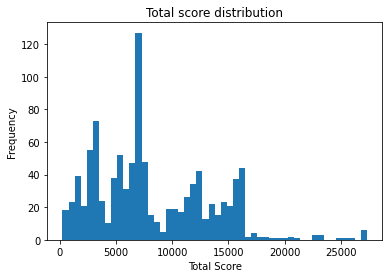

In [ ]:
# Plot best score distribution
plt.hist(scores_DQN, bins = 50)
plt.title("Total score distribution")
plt.xlabel("Total Score")
plt.ylabel("Frequency")
plt.show()


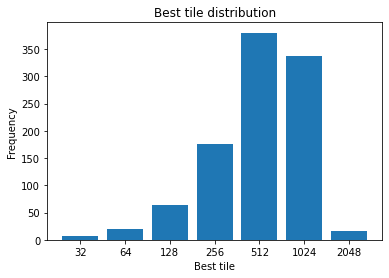

In [ ]:
# Plot best score distribution
max_power = int(math.log(max(best_tiles_DQN), 2)) + 1
min_power = int(math.log(min(best_tiles_DQN), 2))
unique, counts = np.unique(best_tiles_DQN, return_counts=True)
plt.bar([str(2 ** i) for i in range(min_power, max_power)], counts)
plt.title("Best tile distribution")
plt.xlabel("Best tile")
plt.ylabel("Frequency")
plt.show()
